<a href="https://colab.research.google.com/github/ivanrnarvaez/text_mining/blob/main/2_TextRepresentation_tecnicasBoW_master_alumnos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Representación numérica de textos
En la mayoría de técnicas empleadas en Text Mining y Procesamiento de Lenguaje Natural, es fundamental transformar los textos en representaciones numéricas que puedan ser procesadas por modelos estadísticos o de aprendizaje automático. Aunque existen distintas formas de lograr esta transformación, todas ellas se basan en la misma idea: proyectar el contenido textual en un espacio vectorial, es decir, convertir palabras o documentos en vectores de números.


Por una parte, nos encontramos **estrategias léxicas** para representar documentos completos en el espacio vectorial. En estas técnicas, últimamente en desuso en producción pero muy útiles para llevar a cabo análisis preliminares, se construyen matrices que reflejan la frecuencia o relevancia de los términos en cada documento. Este tipo de representación, basada en la **presencia y frecuencia de palabras de un vocabulario en un documento**, resulta especialmente útil en tareas como la clasificación de textos, el topic modeling o la búsqueda de información en grandes volúmenes de datos.

Por otro lado, existen **estrategias semánticas** que permiten representar los textos a un nivel más granular, es decir, palabra por palabra. Estas representaciones, conocidas como **embeddings**, asignan a cada token un vector numérico que encapsula parte de su significado semántico. A diferencia de los modelos más simples, los embeddings permiten capturar similitudes y relaciones semánticas entre palabras, lo que los hace muy eficaces para tareas más complejas como la extracción de entidades, el análisis semántico o el entendimiento contextual del lenguaje. Además, a **partir de estos vectores individuales es posible construir representaciones vectoriales de documentos completos**

En este notebook se trabajará en el primer caso, la representación vectorial a nivel de documento utliizando técnicas léxicas. En el siguiente notebook exploraremos el mundo de los embeddings y su semántica.






## 1. Nociones sobre representación numérica de documentos

En este notebook vamos a aprender a representar numéricamente documentos a través de los métodos de representación Bag-of-Words (BoW) y TF-IDF.


Para este ejercicio trabajaremos con un corpus muy sencillo, para entender la nocion del funcionamiento de estas técnicas de representación:

In [1]:
corpus = ["yo quiero agua",
          "yo quiero cocacola",
          "yo quiero agua y un agua",
          "yo no quiero vino",
          "yo quiero un entrecot"]

Vamos a tokenizar cada una de las frases, para trabajar comodamente más adelante:

In [2]:
corpus_tok = [i.split() for i in corpus]  #Corpus conocido y sencillo, podemos dividir palabras con split()
corpus_tok

[['yo', 'quiero', 'agua'],
 ['yo', 'quiero', 'cocacola'],
 ['yo', 'quiero', 'agua', 'y', 'un', 'agua'],
 ['yo', 'no', 'quiero', 'vino'],
 ['yo', 'quiero', 'un', 'entrecot']]

### Bag of Words
Como hemos visto anterioremente, Bag Of Words es uno de los modelos de representación de texto más intuitivos. Para implementarlo, se construye un vocabulario de tamaño N con los tokens únicos del corpus de trabajo, para despues representar cada documento con un vector del mismo tamaño en el que cada elemento será el nº de veces que aparece el token en cuestión en el documento.



En primer lugar, construimos el vocabulario que se utilizará para representar nuestro corpus:

In [3]:
# El vocabulario de nuestro corpus son los tokens únicos utilizados en nuestro conjunto de documentos
import itertools
import numpy as np

# * operador de desempaquetado: concatenar todos los sublistas (o secuencias) de corpus_tok en un solo iterador plano, que puedes convertir en una lista si quieres
all_tokens = itertools.chain(*corpus_tok)
vocab = sorted(set(all_tokens))

print("Nuestro vocabulario contiene {} tokens. Que son: {}".format(len(vocab),vocab))

Nuestro vocabulario contiene 9 tokens. Que son: ['agua', 'cocacola', 'entrecot', 'no', 'quiero', 'un', 'vino', 'y', 'yo']


Cada uno de los documentos del corpus estará representado por un vector de 9 elementos. El elemento 0 representará la presencia del token agua en el documento, el elemento 1 representará la presencia de "cocacola" en el documento... etc

A continuación, vamos a construir esos vectores:

In [4]:
import collections
# Creamos un vector de salida
doc_vectors = list()
# Iteramos en cada uno de los documentos del corpus
for doc in corpus_tok:
  # Contamos las ocurrencias de cada uno de los tokens. Counter devuelve un diccionario
  counter_doc = collections.Counter(doc) # collections.Counter
  # Creamos el vector que representará al documento
  doc_vec = list()
  # Iteramos por los términos del voabulario
  for word in vocab:
    # Si el término está en el diccionario de conteo, introducimos el valor en
    # esa posición del vector. Si no está, introducimos un 0
    if word in counter_doc:
      doc_vec.append(counter_doc[word]) #counter_doc[word]
    else:
      doc_vec.append(0)
  # Añadimos al vector de salida el vector del documento
  doc_vectors.append(doc_vec)

In [5]:
for frase, vector in zip(corpus, doc_vectors):
  print("La frase '{}' está representada por el vector {}".format(frase, vector))

La frase 'yo quiero agua' está representada por el vector [1, 0, 0, 0, 1, 0, 0, 0, 1]
La frase 'yo quiero cocacola' está representada por el vector [0, 1, 0, 0, 1, 0, 0, 0, 1]
La frase 'yo quiero agua y un agua' está representada por el vector [2, 0, 0, 0, 1, 1, 0, 1, 1]
La frase 'yo no quiero vino' está representada por el vector [0, 0, 0, 1, 1, 0, 1, 0, 1]
La frase 'yo quiero un entrecot' está representada por el vector [0, 0, 1, 0, 1, 1, 0, 0, 1]


En Bag Of Words:

- Los términos que aparecen varias veces en el documento tienen un número mayor, lo que se puede traducir en que esos términos (caracteristicas) tienen un mayor peso en el documento.
- Si un término ocurre muchas veces en todos los documentos, tendrá gran importancia en cada uno de ellos, a pesar de que no será útil para clasificar o agrupar textos.


El método de representación TF-IDF intenta precisamente  compensar este efecto mediante la aplicación de una penalización a palabras comunes en muchos documentos.

### TF-IDF  (intuición)


Para realizar los cáculos de forma más eficiente generaremos un diccionario que asocie a cada una de las palabras de nuestro corpus un índice numérico.


Para calcular TF-IDF realizaremos los siguientes pasos:

1. Calcular el Term Frequency (TF). Que se calcula como:
  $$TF(w) = n_{w-in-d} / N_d$$

Anteriormente hemos calculado para cada documento el número de veces que aparecía cada token del vocabulario. Para calcular el TF bastaría con dividir cada uno de los elementos del vector con la suma total de tokens de cada documento.


2. Calcular el componente Inverse-Document Frequency (IDF). Que se calcula como:
$$ IDF(w) = ln(N/n_w)$$

donde n_w  es el número de documentos que contiene el token w y N es el número total de documentos.

En primer lugar generamos una función que permita calcular el número de vees que un token aparece en un documento d enuestro corpus.

Despues, uniríamos ambas expresiones para calcular el TF-IDF de una frase (las siguientes celdas son de pseudocódigo):



```python

def tf_idf_calc(doc, N_corpus):
  # Generamos vector salida
  tf_idf_vec = np.zeros((len(vocab),))
  for word in doc:
    # Calculamoes el valor tf para el token en cuestion
    tf = TF_calc(doc, word)
    # Calculamos el valor idf para el token en cuestion
    idf = idf_calc(doc, N_corpus)

    tf_idf = tf * idf
    tf_idf_vec[index_dict[word]] = tf_idf
  return tf_idf_vec
```



Y lo aplicaríamos a todo el corpus:




```python
#TF-IDF Encoded text corpus
tf_idf_result = []
for sent in corpus_tok:
    vec = tf_idf_calc(sent,len(corpus_tok))
    tf_idf_result.append(vec)
```



## 2. Vectorización con scikit-learn




Aunque hemos mostrado una manera de aplicar el BoW y Tf-IDF a un corpus de documentos. Existen varias modificaciones que pueden mejorar los resultados (modificaciones en el cálculo de la componente IDF, por ejemplo). Además, las librerías de ML están preapradas para transformar documentos de forma más inmedianta, eficiente e incorporando funciones que pueden ser de utilidad


En scikit-learn podemos utilizar distintas funciones para obtener el vocabulario de un corpus de documentos. Ambas están presentes dentro del módulo feature_extraction.text y son [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) y  [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer).
Vamos a crear un objeto con cada una de esas clases para introducir nuestro corpus y extraer el vocabulario.


**Tanto las funciones CountVectorizer como TfidfVectorizer cuentan con muchos parámetros personalizables. Algunos de los más relevantes son:**


*   *strip_accents*: Elimina los acentos en codificación ascii o unicode. Por defecto es None. Es preferible hacer una gestión de acentos previas.
*   *lowercase*: Transforma todos los caracteres a minúsculas antes de hacer la tokenización.
*   *tokenizer*: Utiliza un tokenizador específico. Se puede utilizar una de NLTK o de Spacy(computacionalmente menos eficiente).
*   *stop_words*: Si se pone el valor "english" eliminara la lista de stop_words definida en scikit-learn. Se puede utilizar la lista de stopwords de otras librerías o definir unas propias.
*   *ngram_range*: Cálculo de n-gramas en el proceso. Mediante la tubla (min_n, max_n) se pueden incorporar n-gramas al cálculo de la matriz tfidf.
*   *max_df*: Valor por defecto 1.  Ignora los tokens (o n-gramas) que aparecen en más del X % de documentos cuando es menor de 1. Si max_df es mayor que uno se ignorarán los términos que aparecen en más de X documentos.
*   *min_df*: Valor por defecto 1. Ignora los tokens que aparecen  en menos del X % de los documentos. Siendo X el valor de X. (0.01 = 1%, por ejemplo)
*   *max_features*: Máximas características que devuelve la función TfidfVectorizer. Valor mayor que 1. Representa las caracaterísticas más importantes (las más repetidas o comunes) Esto es muy interesante para no sobreentrenar el sistema.
*   *norm*: Valores "l1" y "l2", por defecto "l2". Normaliza los valores entre 0 y 1.
*   *use_idf*: Habilita el uso del inverse-document frequency en la función. Por defecto es True.
*   *smooth_idf*: Suaviza los pesos de IDF sumando una unidad a cada frecuencia. Es muy importante para evitar divisiones por cero.



In [6]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.feature_extraction import text

# Creamos los objetos
count_vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer(norm=None, smooth_idf=False) # norm=None, smooth_idf=False Re-escribimos los valores por defecto para tener el tf-idf básico

# Hacemos Fit con nuestro corpus
count_data = count_vectorizer.fit(corpus)   # count_vectorizer.fit(corpus)
tfidf_data = tfidf_vectorizer.fit(corpus)  # tfidf_vectorizer.fit(corpus)

In [7]:
# Obtenemos los vocabularios de dos formas:
print("COUNT VECTORIZER")
print("Obtenemos el vocabulario en si mismo como una lista")
print(count_data.get_feature_names_out())
print("Numero de características:")
print(len(count_data.get_feature_names_out()))

COUNT VECTORIZER
Obtenemos el vocabulario en si mismo como una lista
['agua' 'cocacola' 'entrecot' 'no' 'quiero' 'un' 'vino' 'yo']
Numero de características:
8


In [8]:
# Obviamente, dado que hemos utilizado el mismo corpus, obtenemos el mismo resultado con el tfidf_vectorizer.
print("\n\n TF-IDF VECTORIZER")
print("Obtenemos el vocabulario en si mismo como una lista")
print(tfidf_data.get_feature_names_out())
print("Numero de características:")
print(len(tfidf_data.get_feature_names_out()))



 TF-IDF VECTORIZER
Obtenemos el vocabulario en si mismo como una lista
['agua' 'cocacola' 'entrecot' 'no' 'quiero' 'un' 'vino' 'yo']
Numero de características:
8


Si imprimimos el objeto tfidf_data podemos ver la configuración de los parámetros de TfidfVectorizer:

In [9]:
tfidf_data

TfidfVectorizer(norm=None, smooth_idf=False)

A continuación se muestra el resultado de transformar nuestro corpus con lso métodos de scikit-learn. El `CountVectorizer` mostrará el conteo de veces que una palabra del vocabulario está presente dentro del documento, el `TfidfVectorizer` mostrará el resultado con la métrica TF-IDF mostrada en los apuntes.

In [10]:
# Resultado del CountVectorizer
count_data_result = count_data.transform(corpus).toarray()
print(count_data_result)

[[1 0 0 0 1 0 0 1]
 [0 1 0 0 1 0 0 1]
 [2 0 0 0 1 1 0 1]
 [0 0 0 1 1 0 1 1]
 [0 0 1 0 1 1 0 1]]


In [11]:
# Resultado del TfidfVectorizer
tfidf_data_result = tfidf_data.transform(corpus).toarray()  # transform(corpus)
print(tfidf_data_result)

[[1.91629073 0.         0.         0.         1.         0.
  0.         1.        ]
 [0.         2.60943791 0.         0.         1.         0.
  0.         1.        ]
 [3.83258146 0.         0.         0.         1.         1.91629073
  0.         1.        ]
 [0.         0.         0.         2.60943791 1.         0.
  2.60943791 1.        ]
 [0.         0.         2.60943791 0.         1.         1.91629073
  0.         1.        ]]


Vamos a mostrar los resultados con seaborn para que se vean mejor. Importante mencionar que esto se puede hacer cuando el vocabulario es muy reducido, si no podría ocasionar problemas en la memoria.

<Axes: >

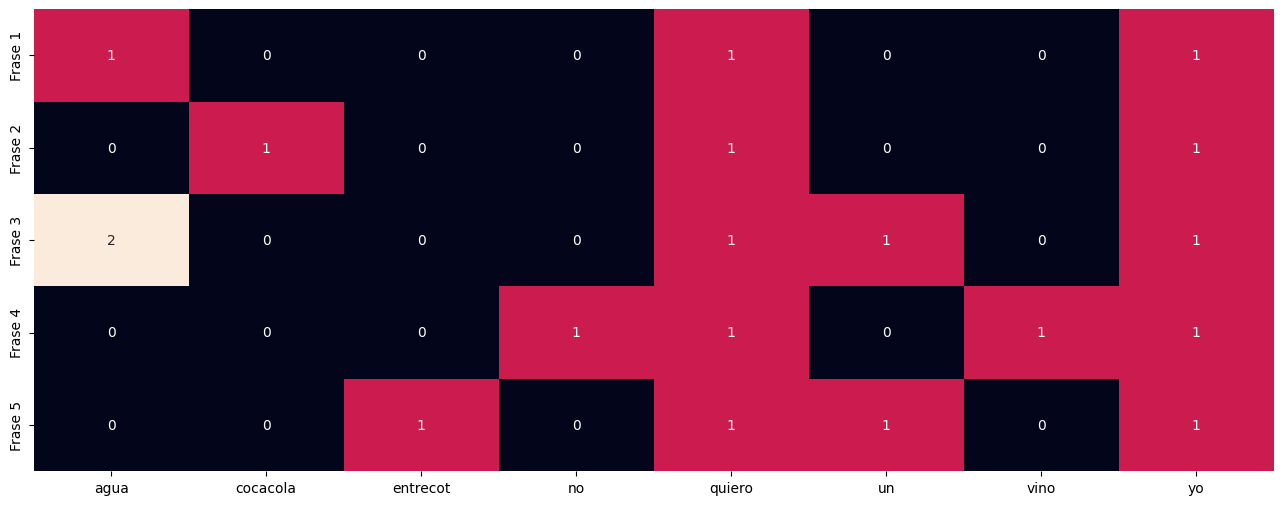

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(16, 6))
# Figura CountVectorizer
sns.heatmap(count_data_result, annot=True,cbar=False,
            xticklabels=count_data.get_feature_names_out(),
            yticklabels = ["Frase 1", "Frase 2", "Frase 3","Frase 4", "Frase 5"])



<Axes: >

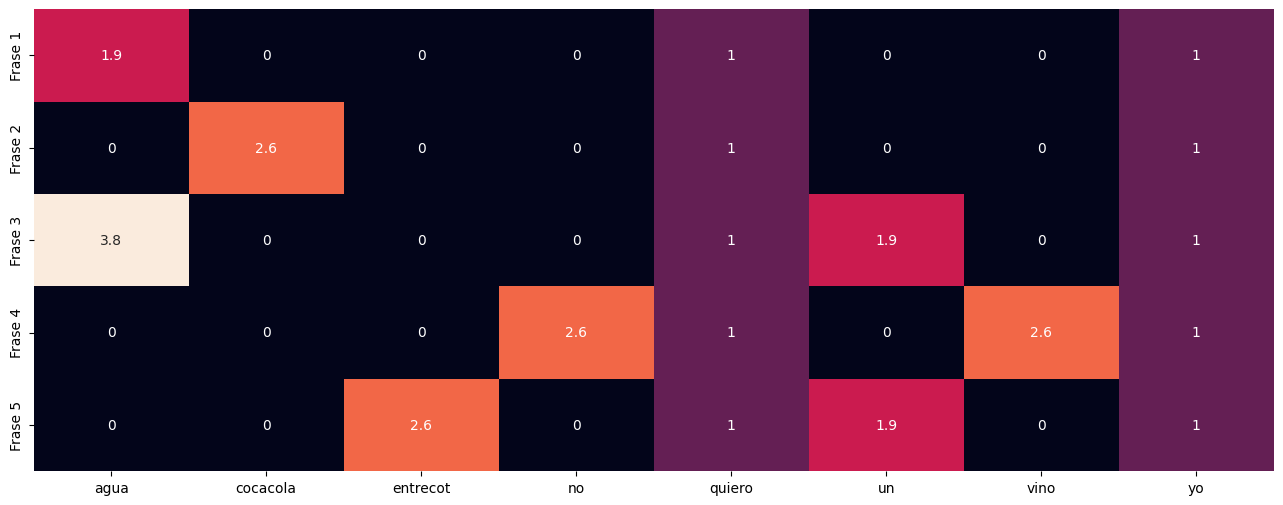

In [13]:
plt.figure(figsize=(16, 6))
sns.heatmap(tfidf_data_result, annot=True,cbar=False,
            xticklabels=tfidf_data.get_feature_names_out(),
            yticklabels = ["Frase 1", "Frase 2", "Frase 3","Frase 4", "Frase 5"])

### Uso de preprocesadores externos a scikit-learn




En primer lugar, dado que vamos a utilizar spacy, instalaremos la librería y el modelo:

In [14]:
!pip install spacy
!python -m spacy download es_core_news_sm
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 83.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 57.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Importamos las librerías y creamos el objeto "nlp" para procesar los textos




In [17]:
import spacy
import es_core_news_sm
nlp = spacy.load('es_core_news_sm')  #es_core_news_sm

Guardamos las stop words de Spacy en una variable llamada "stop_words". También cogemos los tokens considerados símbolos de punctuación en la variable "punctuations":

In [18]:
import string
spacy_stopwords = spacy.lang.es.stop_words.STOP_WORDS
stop_words = spacy_stopwords
punctuations=string.punctuation

Generamos una función "spacy_tokenizer" que:

In [19]:
def spacy_tokenizer(sentence):
    # Pasamos la frase por el objeto nlp para procesarla
    mytokens = nlp(sentence)

    # Lematizamos los tokens y los convertimos  a minusculas
    mytokens = [ word.lemma_.lower().strip() for word in mytokens ]

    # Quitamos las stopwords y los signos de puntuacion
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # devolver una lsita de tokens
    return mytokens

Utilizamos esa función como tokenizador en TfidfVectorizer:


In [20]:
tfidf_vectorizer = TfidfVectorizer(norm=None, smooth_idf=False, tokenizer = spacy_tokenizer) # Re-escribimos los valores por defecto para tener el tf-idf básico
tfidf_data = tfidf_vectorizer.fit(corpus)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [21]:
print("\n\n TF-IDF VECTORIZER")
print("Obtenemos el vocabulario en si mismo como una lista")
print(tfidf_data.get_feature_names_out())
print("Numero de características:")
print(len(tfidf_data.get_feature_names_out()))



 TF-IDF VECTORIZER
Obtenemos el vocabulario en si mismo como una lista
['agua' 'cocacola' 'entrecot' 'querer' 'vino']
Numero de características:
5


**Ejercicio**:

Queremos transformar nuestro dataset de noticias con las siguientes especificaciones:
 - Transformar los primeros 3000 documentos
 - Se utilice idf y el valor de norm por defecto.
 - Se utilice la función de preprocesado de spacy utilizada anteriormente
 - Se consideren unigramas, bigramas, trigramas
 - El vectorizador no debe considerar los elementos que aparezcan en menos del 5% de documentos.

In [22]:
# Dataset de noticias
!wget "https://github.com/luisgasco/ntic_master_datos/raw/main/datasets/news_summary.csv"

--2025-06-30 16:38:26--  https://github.com/luisgasco/ntic_master_datos/raw/main/datasets/news_summary.csv
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/luisgasco/ntic_master_datos/main/datasets/news_summary.csv [following]
--2025-06-30 16:38:27--  https://raw.githubusercontent.com/luisgasco/ntic_master_datos/main/datasets/news_summary.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11896415 (11M) [application/octet-stream]
Saving to: ‘news_summary.csv’

news_summary.csv    100%[===================>]  11.34M  --.-KB/s    in 0.08s   

2025-06-30 16:38:28 (136 MB/s) - ‘news_summary.csv’ save

In [23]:
import pandas as pd
news_summary = pd.read_csv('../content/news_summary.csv', encoding='latin-1')
news_subset = news_summary["text"].to_list()[0:3000]

In [24]:
import en_core_web_sm
nlp = en_core_web_sm.load()
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
stop_words = spacy_stopwords
punctuations=string.punctuation

In [25]:
def spacy_tokenizer(sentence):
    # Pasamos la frase por el objeto nlp para procesarla
    mytokens = nlp(sentence)

    # Lematizamos los tokens y los convertimos  a minusculas
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Quitamos las stopwords y los signos de puntuacion
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # Quitamos números:
    mytokens = ['NUM' if word.isdigit() else word for word in mytokens  ]
    # devolver una lsita de tokens
    return mytokens

In [26]:
tfidf_vect = TfidfVectorizer(norm='l2', use_idf=True,
                             smooth_idf=True,
                             tokenizer=spacy_tokenizer,
                             ngram_range=(1,3),
                             min_df=0.05)
tfidf_data = tfidf_vect.fit(news_subset)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [27]:
tfidf_data_t = tfidf_data.transform(news_subset)

In [28]:
tfidf_data_t

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 14836 stored elements and shape (3000, 56)>

In [29]:
tfidf_data.get_feature_names_out()

array(['...', 'NUM', 'NUM NUM', 'NUM year', 'NUM year old', 'accord',
       'accuse', 'actor', 'add', 'allegedly', 'arrest', 'ask', 'case',
       'chief', 'claim', 'come', 'country', 'court', 'crore', 'day',
       'delhi', 'early', 'far', 'film', 'find', 'follow', 'friday',
       'government', 'high', 'include', 'india', 'indian', 'lakh', 'like',
       'man', 'minister', 'monday', 'month', 'mumbai', 'new', 'notably',
       'official', 'old', 'party', 'people', 'police', 'president',
       'report', 'reportedly', 'state', 'time', 'tuesday', 'use', 'woman',
       'year', 'year old'], dtype=object)

## 3. [EXTRA] - Diferencias entre BoW y TF-IDF


Hasta el momento hemos visto diferente maneras de realizar la representación de documentos utilizando el método BoW y TF-IDF.
Sin embargo, ¿Qué implica realmente utilizar un método u otro?

La clave de TF-IDF es su penalización de palabras comunes en todos los documentos. Para ver su efecto, en este apartado vamos a:
1. Descargar un conjunto de documentos de wikipedia
2. Preprocesarlos
3. Mostrar los 10 términos más importantes para BoW y Tf-IDF, y ver las diferencias

En primer lugar importanmos y descargamos las librerías que utilizaremos


In [31]:
!pip install wikipedia
import wikipedia
import spacy
import collections
import math
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.feature_extraction import text
import string
import numpy as np
import re

nlp = spacy.load('en_core_web_sm')
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
stop_words = spacy_stopwords
punctuations=string.punctuation
RE_WHITESPACE = re.compile(r"\s+")


  Using cached wikipedia-1.4.0.tar.gz (27 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11678 sha256=df43abd79c7c4dfd84e5e5c464f1c578f77886b79289d59b226df12bac29b47c
  Stored in directory: /root/.cache/pip/wheels/8f/ab/cb/45ccc40522d3a1c41e1d2ad53b8f33a62f394011ec38cd71c6
Successfully built wikipedia


Definimos una función de procesado similar a la anteriormente definida. En este caso eliminarmos los números (no los sustitumos por un caracter vacío). Además, eliminamos posibles espacios extras despues del proceso de tokenización

In [32]:
def spacy_tokenizer(sentence):
    # Pasamos la frase por el objeto nlp para procesarla
    mytokens = nlp(sentence)

    mytokens = [ word.text.lower()   if word.pos_ == 'PRON' or word.lemma_ == '-PRON-' else word.lemma_.lower() for word in mytokens]

    # Lematizamos los tokens y los convertimos  a minusculas
 #   mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Quitamos las stopwords y los signos de puntuacion
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # Quitamos números:
    mytokens = [word  for word in mytokens if not word.isdigit()]
    # Remove extra spaces
    mytokens = [token.strip() for token in mytokens]
    # devolver una lsita de tokens
    return mytokens


Vamos a descargar el texto de descripción de varios guitarristas históricos. Para ello definiremos una lista de strings con sus nombres y los obtendremos utilizando la función "page" de la librería wikipedia.


In [33]:
pages =  [
  "Brian May","jimmy page","eddie van halen","david gilmour",
  "Jeff Beck","mark knopfler","Billy Gibbons","Carlos Santana",
  "Stevie Ray Vaughan","BB king","Buddy Guy","Albert King","Rory Gallagher",
  "Joe Satriani", "jimi hendrix","George Harrison"
    ]
documentes = [RE_WHITESPACE.sub(" ",wikipedia.page(page, auto_suggest=False).content).strip() for page in pages]

Calculamos y entrenamos vectorizadores TFIDF y BoW (CountVectorizer) para el corpus descargado y preprocesado:

In [35]:
tfidf_vect = TfidfVectorizer(lowercase = False, stop_words = None, use_idf = True, smooth_idf = False,
                             norm = "l2", tokenizer=spacy_tokenizer)
count_vect = CountVectorizer(lowercase = False, stop_words = None, tokenizer=spacy_tokenizer)

tfidf_data = tfidf_vect.fit(documentes)
count_data = count_vect.fit(documentes)

Generamos funciones para obtener las palabras más importantes del vectorizador:


In [36]:
tfidf_feature_names = np.array(tfidf_data.get_feature_names_out())
count_feature_names = np.array(count_data.get_feature_names_out())

def get_top_vect_words(response, top_n=2,feature_name_array=tfidf_feature_names):
  # De la respuesta del vectorizador, cogemos los datos en bruto del array, los ordenamos
  # de mayor a menor y cogemos los índices de los top_n terminos. Que se seleccionarán del
  # los nombres de las caracteristicas (tokens) del vectorizador.
    sorted_nzs = np.argsort(response.data)[:-(top_n+1):-1]
    return feature_name_array[response.indices[sorted_nzs]]


Generamos está función para mostrar los 10 términos más importantes de un documento vectorizado con TF-IDF y BoW para ver sus diferencias.

In [37]:
def show_doc_results(doc,top_n):
  responses_tfidf = tfidf_vect.transform([doc])
  responses_count = count_vect.transform([doc])
  most_frequent = list(get_top_vect_words(responses_count,top_n,count_feature_names))
  tfidf = list(get_top_vect_words(responses_tfidf,top_n,tfidf_feature_names))
  print("Tokens más frecuentes: {}".format(most_frequent))
  print("Tokens con mayor TF-IDF: {}".format(tfidf))

In [38]:
for i in range(0, len(pages)):
  print(pages[i])
  show_doc_results(documentes[i],10)

Brian May
Tokens más frecuentes: ['queen', 'guitar', 'album', 'use', 'band', 'song', 'rock', 'work', 'perform', 'tour']
Tokens con mayor TF-IDF: ['queen', 'badger', 'guitar', 'mercury', 'animal', 'welfare', 'lambert', 'album', 'use', 'band']
jimmy page
Tokens más frecuentes: ['page', 'guitar', 'zeppelin', 'led', 'play', 'album', 'use', 'record', 'session', 'band']
Tokens con mayor TF-IDF: ['page', 'zeppelin', 'led', 'guitar', 'play', 'yardbirds', 'plant', 'album', 'use', 'record']
eddie van halen
Tokens más frecuentes: ['van', 'halen', 'guitar', 'eddie', 'band', 'album', 'play', 'later', 'use', 'work']
Tokens con mayor TF-IDF: ['halen', 'van', 'eddie', 'guitar', 'evh', 'wolfgang', 'simmons', 'bertinelli', 'band', 'frankenstrat']
david gilmour
Tokens más frecuentes: ['gilmour', 'album', 'pink', 'floyd', 'guitar', 'release', 'solo', 'use', 'include', 'play']
Tokens con mayor TF-IDF: ['gilmour', 'pink', 'floyd', 'barrett', 'album', 'guitar', 'samson', 'release', 'wright', 'strat']
Jeff Be

Observar diferencias de palabras muy comunes en documentos de guitarristas como "guitar", "release","play" o "album". En BoW aparecen como términos muy importantes porque son comunes en este tipo de documentos. Sin embargo, al calcular el TF-IDF, como estos términos aparecen en muchos documentos su importancia se ve disminuida.
